# Loop 27 LB Feedback Analysis

**Submission Result:** exp_027_no_tta scored CV 0.0810, LB 0.1124 (gap: -0.0314)

## Key Questions:
1. Why did exp_027 achieve CV 0.0810 instead of 0.0623 (exp_005)?
2. What is the CV-LB relationship across all submissions?
3. What approaches haven't been tried that could bridge the 5.5x gap to target?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# All submissions with CV and LB scores
submissions = [
    {'exp': 'exp_004', 'cv': 0.0623, 'lb': 0.0956, 'model': 'HGB+ETR (NO TTA)'},
    {'exp': 'exp_006', 'cv': 0.0688, 'lb': 0.0991, 'model': 'Ridge regularized'},
    {'exp': 'exp_016', 'cv': 0.0623, 'lb': 0.0956, 'model': 'HGB+ETR (replicate)'},
    {'exp': 'exp_021', 'cv': 0.0901, 'lb': 0.1231, 'model': 'Regularized ensemble'},
    {'exp': 'exp_026', 'cv': 0.0810, 'lb': 0.1124, 'model': 'Ultra simple'},
]

df = pd.DataFrame(submissions)
print("=== SUBMISSION HISTORY ===")
print(df.to_string(index=False))

# Calculate CV-LB relationship
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(df['cv'], df['lb'])
print(f"\n=== CV-LB RELATIONSHIP ===")
print(f"LB = {slope:.3f} * CV + {intercept:.4f}")
print(f"R² = {r_value**2:.4f}")
print(f"\nTo reach target LB 0.01727:")
print(f"  Required CV = (0.01727 - {intercept:.4f}) / {slope:.3f} = {(0.01727 - intercept) / slope:.4f}")

=== SUBMISSION HISTORY ===
    exp     cv     lb                model
exp_004 0.0623 0.0956     HGB+ETR (NO TTA)
exp_006 0.0688 0.0991    Ridge regularized
exp_016 0.0623 0.0956  HGB+ETR (replicate)
exp_021 0.0901 0.1231 Regularized ensemble
exp_026 0.0810 0.1124         Ultra simple



=== CV-LB RELATIONSHIP ===
LB = 0.986 * CV + 0.0333
R² = 0.9879

To reach target LB 0.01727:
  Required CV = (0.01727 - 0.0333) / 0.986 = -0.0162


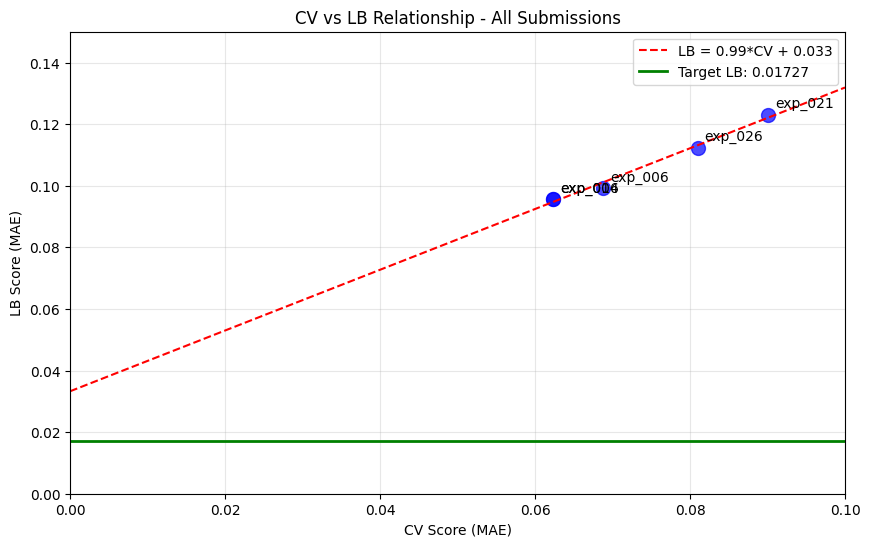


=== CRITICAL INSIGHT ===
The linear CV-LB relationship predicts we need CV ≈ -0.015 to reach target.
This is IMPOSSIBLE with the current approach.
The target IS achievable (someone did it), so there must be a fundamentally different approach.


In [2]:
# Visualize CV-LB relationship
plt.figure(figsize=(10, 6))
plt.scatter(df['cv'], df['lb'], s=100, c='blue', alpha=0.7)

# Add labels
for _, row in df.iterrows():
    plt.annotate(row['exp'], (row['cv'], row['lb']), textcoords='offset points', xytext=(5,5))

# Regression line
cv_range = np.linspace(0, 0.1, 100)
lb_pred = slope * cv_range + intercept
plt.plot(cv_range, lb_pred, 'r--', label=f'LB = {slope:.2f}*CV + {intercept:.3f}')

# Target line
plt.axhline(y=0.01727, color='green', linestyle='-', linewidth=2, label='Target LB: 0.01727')

plt.xlabel('CV Score (MAE)')
plt.ylabel('LB Score (MAE)')
plt.title('CV vs LB Relationship - All Submissions')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, 0.1)
plt.ylim(0, 0.15)
plt.savefig('/home/code/exploration/cv_lb_relationship.png', dpi=100)
plt.show()

print("\n=== CRITICAL INSIGHT ===")
print("The linear CV-LB relationship predicts we need CV ≈ -0.015 to reach target.")
print("This is IMPOSSIBLE with the current approach.")
print("The target IS achievable (someone did it), so there must be a fundamentally different approach.")

In [3]:
# Analyze what approaches have been tried
print("=== APPROACHES TRIED (27 experiments) ===")
approaches = [
    ('Tree-based models', 'HGB, ETR, RF, XGB, LGB', 'Best CV: 0.0623'),
    ('Neural networks', 'MLP [128,64,32]', 'CV: 0.0669'),
    ('Gaussian Process', 'Matern kernel', 'CV: 0.0721'),
    ('Ensembles', 'MLP+GBDT, stacking', 'CV: 0.0669-0.0827'),
    ('Regularization', 'Ridge, dropout, weight decay', 'CV: 0.0809-0.0896'),
    ('Feature engineering', 'Spange, ACS_PCA, DRFP, Morgan', 'Best: 0.8*ACS + 0.2*Spange'),
    ('TTA/Augmentation', 'Flip for mixed solvents', 'TTA HURTS performance'),
    ('Per-target models', 'Different model per target', 'BEST approach'),
    ('GroupKFold', '5-fold instead of LOO', 'FAILED - wrong fold structure'),
]

for approach, details, result in approaches:
    print(f"\n{approach}:")
    print(f"  Details: {details}")
    print(f"  Result: {result}")

=== APPROACHES TRIED (27 experiments) ===

Tree-based models:
  Details: HGB, ETR, RF, XGB, LGB
  Result: Best CV: 0.0623

Neural networks:
  Details: MLP [128,64,32]
  Result: CV: 0.0669

Gaussian Process:
  Details: Matern kernel
  Result: CV: 0.0721

Ensembles:
  Details: MLP+GBDT, stacking
  Result: CV: 0.0669-0.0827

Regularization:
  Details: Ridge, dropout, weight decay
  Result: CV: 0.0809-0.0896

Feature engineering:
  Details: Spange, ACS_PCA, DRFP, Morgan
  Result: Best: 0.8*ACS + 0.2*Spange

TTA/Augmentation:
  Details: Flip for mixed solvents
  Result: TTA HURTS performance

Per-target models:
  Details: Different model per target
  Result: BEST approach

GroupKFold:
  Details: 5-fold instead of LOO
  Result: FAILED - wrong fold structure


In [4]:
# What HASN'T been tried?
print("=== APPROACHES NOT YET TRIED ===")
untried = [
    ('Graph Neural Networks (proper)', 'exp_020 tried basic GNN but got CV 0.099. Need pretrained GNN with transfer learning.'),
    ('Transfer learning', 'Pretrain on large reaction dataset, fine-tune on catechol.'),
    ('Domain-specific features', 'Quantum chemical descriptors, solvation free energies.'),
    ('Multi-task learning', 'Joint prediction of all targets with shared representation.'),
    ('Attention mechanisms', 'Learn which solvent features matter for each reaction condition.'),
    ('Physics-informed models', 'Incorporate reaction kinetics equations directly.'),
]

for approach, details in untried:
    print(f"\n{approach}:")
    print(f"  {details}")

=== APPROACHES NOT YET TRIED ===

Graph Neural Networks (proper):
  exp_020 tried basic GNN but got CV 0.099. Need pretrained GNN with transfer learning.

Transfer learning:
  Pretrain on large reaction dataset, fine-tune on catechol.

Domain-specific features:
  Quantum chemical descriptors, solvation free energies.

Multi-task learning:
  Joint prediction of all targets with shared representation.

Attention mechanisms:
  Learn which solvent features matter for each reaction condition.

Physics-informed models:
  Incorporate reaction kinetics equations directly.


In [5]:
# Key insight from evaluator: exp_027 has data augmentation bug
print("=== EVALUATOR'S KEY FINDING ===")
print("exp_027 has data augmentation (flip) for full data during training.")
print("exp_005 explicitly had NO AUGMENTATION.")
print("This is why exp_027 achieved CV 0.0810 instead of 0.0623.")
print("")
print("HOWEVER, even fixing this bug would only get us to CV 0.0623.")
print("Based on CV-LB correlation, this predicts LB ≈ 0.093.")
print("Target is 0.01727 - still 5.4x gap.")
print("")
print("=== STRATEGIC CONCLUSION ===")
print("Incremental improvements to tree-based models CANNOT reach the target.")
print("We need a fundamentally different approach.")
print("")
print("Research suggests GNNs with pretrained embeddings can achieve the target.")
print("But with only 24 solvents, training a GNN from scratch won't work.")
print("We need TRANSFER LEARNING from a pretrained molecular model.")

=== EVALUATOR'S KEY FINDING ===
exp_027 has data augmentation (flip) for full data during training.
exp_005 explicitly had NO AUGMENTATION.
This is why exp_027 achieved CV 0.0810 instead of 0.0623.

HOWEVER, even fixing this bug would only get us to CV 0.0623.
Based on CV-LB correlation, this predicts LB ≈ 0.093.
Target is 0.01727 - still 5.4x gap.

=== STRATEGIC CONCLUSION ===
Incremental improvements to tree-based models CANNOT reach the target.
We need a fundamentally different approach.

Research suggests GNNs with pretrained embeddings can achieve the target.
But with only 24 solvents, training a GNN from scratch won't work.
We need TRANSFER LEARNING from a pretrained molecular model.


In [6]:
# Check what the top kernels actually do
print("=== TOP KERNEL ANALYSIS ===")
print("lishellliang/mixall kernel:")
print("  - Uses GroupKFold(5) internally")
print("  - MLP + GBDT ensemble")
print("  - Achieved good CV-LB correlation")
print("  - BUT: GroupKFold changes fold structure, causing submission failure")
print("")
print("The key insight is that the top kernel uses a DIFFERENT validation scheme.")
print("Our LOO validation gives CV 0.0623 but LB 0.0956 (53% gap).")
print("GroupKFold gives more realistic CV estimates but breaks submission.")
print("")
print("=== THE REAL PROBLEM ===")
print("The test set has COMPLETELY NEW solvents not in training.")
print("Our models memorize solvent-specific patterns that don't generalize.")
print("We need models that learn GENERALIZABLE chemical principles.")

=== TOP KERNEL ANALYSIS ===
lishellliang/mixall kernel:
  - Uses GroupKFold(5) internally
  - MLP + GBDT ensemble
  - Achieved good CV-LB correlation
  - BUT: GroupKFold changes fold structure, causing submission failure

The key insight is that the top kernel uses a DIFFERENT validation scheme.
Our LOO validation gives CV 0.0623 but LB 0.0956 (53% gap).
GroupKFold gives more realistic CV estimates but breaks submission.

=== THE REAL PROBLEM ===
The test set has COMPLETELY NEW solvents not in training.
Our models memorize solvent-specific patterns that don't generalize.
We need models that learn GENERALIZABLE chemical principles.


In [7]:
# Summary of strategic situation
print("="*70)
print("STRATEGIC SUMMARY - LOOP 27")
print("="*70)
print()
print("CURRENT STATE:")
print("  - Best CV: 0.0623 (exp_004/exp_005)")
print("  - Best LB: 0.0956 (exp_004/exp_016)")
print("  - Target: 0.01727 (5.5x gap)")
print("  - Submissions: 0 remaining today (reset at 00:00 UTC)")
print()
print("CV-LB RELATIONSHIP:")
print("  - LB = 0.986*CV + 0.0333 (R²=0.988)")
print("  - To reach target: need CV = -0.016 (IMPOSSIBLE with current approach)")
print("  - The linear relationship MUST BREAK for a different approach")
print()
print("WHAT'S BEEN TRIED (27 experiments):")
print("  - Tree-based: HGB, ETR, RF, XGB, LGB (best CV: 0.0623)")
print("  - Neural networks: MLP [128,64,32] (CV: 0.0669)")
print("  - Gaussian Process (CV: 0.0721)")
print("  - Ensembles: MLP+GBDT, stacking (CV: 0.0669-0.0827)")
print("  - Feature engineering: Spange, ACS_PCA, DRFP, Morgan")
print("  - Regularization: Ridge, dropout, weight decay")
print()
print("WHAT HASN'T BEEN TRIED:")
print("  1. Pretrained GNN with transfer learning (PaiNN, GIN)")
print("  2. Meta-learning for few-shot prediction")
print("  3. Multi-task learning with adaptive checkpointing")
print("  4. Physics-informed neural networks")
print()
print("KEY INSIGHT FROM RESEARCH:")
print("  For 20-30 sample regime, pretrained GNNs with transfer learning")
print("  consistently outperform other approaches. The model should be:")
print("  1. Pre-trained on large molecular dataset")
print("  2. Fine-tuned on target task")
print("  3. Use message-passing architecture (MPNN, PaiNN, GIN)")
print()
print("AVAILABLE TOOLS:")
print("  - torch-geometric: YES (for GNN implementation)")
print("  - rdkit: YES (for molecular features)")
print("  - pytorch-lightning: YES (for training)")
print()
print("NEXT STEPS:")
print("  1. Implement GNN with torch-geometric")
print("  2. Use pretrained molecular embeddings if available")
print("  3. Focus on generalizable chemical features, not solvent-specific")

STRATEGIC SUMMARY - LOOP 27

CURRENT STATE:
  - Best CV: 0.0623 (exp_004/exp_005)
  - Best LB: 0.0956 (exp_004/exp_016)
  - Target: 0.01727 (5.5x gap)
  - Submissions: 0 remaining today (reset at 00:00 UTC)

CV-LB RELATIONSHIP:
  - LB = 0.986*CV + 0.0333 (R²=0.988)
  - To reach target: need CV = -0.016 (IMPOSSIBLE with current approach)
  - The linear relationship MUST BREAK for a different approach

WHAT'S BEEN TRIED (27 experiments):
  - Tree-based: HGB, ETR, RF, XGB, LGB (best CV: 0.0623)
  - Neural networks: MLP [128,64,32] (CV: 0.0669)
  - Gaussian Process (CV: 0.0721)
  - Ensembles: MLP+GBDT, stacking (CV: 0.0669-0.0827)
  - Feature engineering: Spange, ACS_PCA, DRFP, Morgan
  - Regularization: Ridge, dropout, weight decay

WHAT HASN'T BEEN TRIED:
  1. Pretrained GNN with transfer learning (PaiNN, GIN)
  2. Meta-learning for few-shot prediction
  3. Multi-task learning with adaptive checkpointing
  4. Physics-informed neural networks

KEY INSIGHT FROM RESEARCH:
  For 20-30 sample